In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpzq7f_thr/pubring.gpg' created
gpg: /tmp/tmpzq7f_thr/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [3]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/deep_learning/")
os.chdir("./sentiment_classification")
!ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
bow-cnn.hdf5		       output
count_vectorizer_weights.hdf5  polar.vocab
data			       Sentiment Analysis BOW-CNN.ipynb
data_stopwords		       Sentiment Analysis BOW_MLP-n-grams.ipynb
drive			       Sentiment Classification v1.ipynb
mlpv2.py


### Cleaning code does the following
> convert everything to lower case

> handle negations (convert \"don't\" to \"do not\")

> remove tokens that are not alphabetic

> filter stop words

> remove tokens less than 1 character


In [1]:
from string import punctuation
import os
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import re

import nltk
nltk.download('stopwords')

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def cleanv2(text):
	# convert to lower case
	text = text.lower()
	# change don't to do not, doesn't to does not
	text = neg_pattern.sub(lambda x: negations_dic[x.group()], text)
	# remove remaining tokens that are not alphabetic
	text = re.sub("[^a-zA-Z]", " ", text)
	# tokenize
	tokens = tokenizer.tokenize(text)
	# filter out words less than 1 character
	tokens = [word for word in tokens if len(word) > 1]
	return tokens	

# Function to create or fetch vocabulary
def make_vocab(vocabFile,directory='./sample'): #floyd
	vocabExists = os.path.isfile(vocabFile)
	if vocabExists:
		# Read and return vocab
		print("Found vocab file {}").format(vocabFile)
		vocab = load_doc(vocabFile)
		vocab = vocab.split('\n')
		print("Vocabulary has {} words").format(len(vocab))
	else:
		print("Did not find vocab file {}").format(vocabFile)
		vocab = Counter()
		# walk through all files in the folder
		for path, subdirs, files in os.walk(directory):
			for filename in files:
				# create the full path of the file to open
				filepath =  os.path.join(path, filename)
				# load and clean the doc
				doc = load_doc(filepath)
				tokens = cleanv2(doc)
				vocab.update(tokens)

		print("Number of tokens before filtering freqeuncy of occurance: {}").format(len(vocab))
		vocab = [word for word,freq in vocab.most_common() if freq>2]
		print("Number of tokens occuring more than 2 times: {}").format(len(vocab))
		
		# Save the vocabulary file
		# convert lines to a single blob of text
		data = '\n'.join(vocab)
		# open file
		file = open(vocabFile, 'w+')
		# write text
		print("Saving vocabulary to {}").format(vocabFile)
		file.write(data)
		# close file
		file.close()
	return vocab


# change all files to BoW representation 
# based on frequency of words in each review
# load all docs in a directory into memory
def process_reviews(directory,vocab):
	reviews = list()
	sentiment = list()
	# walk through all files in the folder
	for path, subdirs, files in os.walk(directory):
			for filename in files:
				# create the full path of the file to open
				filepath =  os.path.join(path, filename)
				# load the doc
				doc = load_doc(filepath)
				# clean doc
				tokens = cleanv2(doc)
				# filter by vocab
				tokens = [word for word in tokens if word in vocab]
				review = ' '.join(tokens)
				# append review to reviews
				reviews.append(review)
				# Get the sentiment as well
				sentiment.append(1 if 'pos' in filepath else 0)

	return reviews,sentiment


def get_data(data_file,isTrain=True):
	dataset_type = 'train' if isTrain else 'test'
	if os.path.isfile(data_file):
		print("Found "+dataset_type+" File {}.").format(data_file)
		data = pickle.load(open(data_file, 'rb'))
		X,y = zip(*data)


	else:
		print("Did not find "+dataset_type+" file.")
		vocab = make_vocab('./data_stopwords/polar.vocab','./dataset/train')#floyd
		print("Saved Vocabulary")
		print("processing reviews...")
		X,y = process_reviews('./dataset/'+dataset_type,vocab) #floyd
		data = zip(np.array(X),np.array(y))
		np.array(data).dump('./output/'+dataset_type+'.data') #floyd

	X = np.array(X)
	y = np.array(y)
	print("Found {} samples for "+dataset_type).format(X.shape[0])

	return X,y

def ngram_tokenize(X_train,X_test,max_features=None,ngram=(1,1)):
  from sklearn.feature_extraction.text import CountVectorizer
  vectorizer = CountVectorizer(analyzer = "word", 
                               ngram_range = ngram,
                               binary=False, # If True it is frequency else binary
                               max_features = max_features) 
  vectorizer.fit(X_train)
  X_train = vectorizer.transform(X_train)
  X_test = vectorizer.transform(X_test)
  #print vectorizer.vocabulary_
  return X_train,X_test

def train_model(model, X,y,epochs=10):
	from keras.callbacks import ModelCheckpoint
	X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=30)
	save_model = ModelCheckpoint('bow-cnn.hdf5', monitor='val_loss',save_best_only=True)
	hist = model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=1, callbacks=[save_model],validation_data=(X_val,y_val),shuffle=True )
	return hist

def test_model(model, X_test, y_test):
	print("Testing model on {}").format(X_test.shape[0])
	model.load_weights('bow-cnn.hdf5') #floyd
	loss, acc = model.evaluate(X_test, y_test, verbose=0)
	print('Test Accuracy: %f' % (acc*100))

def plot_loss(hist):
	import matplotlib.pyplot as plt
	loss = hist.history['loss'] #np.loadtxt('my_cnn_model_loss.csv')
	val_loss = hist.history['val_loss'] #np.loadtxt('my_cnn_model_val_loss.csv')

	plt.plot(loss, linewidth=3, label='train')
	plt.plot(val_loss, linewidth=3, label='valid')
	plt.grid()
	plt.legend()
	plt.xlabel('epoch')
	plt.ylabel('loss')
	#plt.ylim(1e-3, 1e-2)
	plt.yscale('log')
	plt.show()

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### With stop words.

In [22]:
train_file = './data_stopwords/train.data' #floyd
test_file = './data_stopwords/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

print("Tokenizing")
X,X_test = ngram_tokenize(X,X_test,max_features=6000,ngram=(1,1))
print(X.shape)
print(X_test.shape)

Found train File ./data_stopwords/train.data.
Found 25000 samples for train
Found test File ./data_stopwords/test.data.
Found 25000 samples for test
Tokenizing
(25000, 6000)
(25000, 6000)


In [0]:
def cnn_modelv1(input_shape):

	from keras.models import Model
	from keras.layers import Input, Dense, Dropout,Conv1D,MaxPooling1D,Flatten

	input_layer = Input(shape=(input_shape[1],input_shape[2],))
	x = Conv1D(64, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
			kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
			bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_layer)
	x = MaxPooling1D(pool_size=2, strides=None, padding='valid')(x)
	
	x = Flatten()(x)
	x = Dense(50,activation='relu')(x)
	x = Dropout(0.5)(x)
	# x = Dense(128,activation='relu')(x)
	# x = Dropout(0.5)(x)
	output_layer = Dense(1,activation='sigmoid')(x)
	model = Model(inputs=input_layer, outputs=output_layer)

	model.summary()

	return model

(25000, 6000)
(25000, 6000, 1)
(25000, 6000, 1)
(25000, 6000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 6000, 1)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5998, 64)          256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2999, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 191936)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                9596850   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (De

20000/20000 [==============================] - 38s 2ms/step - loss: 0.4061 - acc: 0.8243 - val_loss: 0.3233 - val_acc: 0.8640
Epoch 2/20
 7648/20000 [==========>...................] - ETA: 21s - loss: 0.2926 - acc: 0.8798

20000/20000 [==============================] - 38s 2ms/step - loss: 0.2951 - acc: 0.8774 - val_loss: 0.3157 - val_acc: 0.8726
Epoch 3/20
 9792/20000 [=============>................] - ETA: 17s - loss: 0.2465 - acc: 0.8965

20000/20000 [==============================] - 38s 2ms/step - loss: 0.2615 - acc: 0.8905 - val_loss: 0.3093 - val_acc: 0.8794
Epoch 4/20
10592/20000 [==============>...............] - ETA: 16s - loss: 0.2224 - acc: 0.9067

20000/20000 [==============================] - 38s 2ms/step - loss: 0.2309 - acc: 0.9057 - val_loss: 0.3273 - val_acc: 0.8704
Epoch 5/20
10880/20000 [===============>..............] - ETA: 15s - loss: 0.2035 - acc: 0.9143

20000/20000 [==============================] - 38s 2ms/step - loss: 0.2057 - acc: 0.9150 - val_loss: 0.3509 - val_acc: 0.8718
Epoch 6/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1830 - acc: 0.9251

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1870 - acc: 0.9228 - val_loss: 0.3476 - val_acc: 0.8744
Epoch 7/20
11040/20000 [===============>..............] - ETA: 15s - loss: 0.1737 - acc: 0.9247

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1739 - acc: 0.9248 - val_loss: 0.4063 - val_acc: 0.8750
Epoch 8/20
11072/20000 [===============>..............] - ETA: 15s - loss: 0.1468 - acc: 0.9373

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1570 - acc: 0.9335 - val_loss: 0.3868 - val_acc: 0.8734
Epoch 9/20
11072/20000 [===============>..............] - ETA: 15s - loss: 0.1447 - acc: 0.9379

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1462 - acc: 0.9387 - val_loss: 0.4138 - val_acc: 0.8674
Epoch 10/20
11040/20000 [===============>..............] - ETA: 15s - loss: 0.1300 - acc: 0.9437

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1351 - acc: 0.9410 - val_loss: 0.4697 - val_acc: 0.8732
Epoch 11/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1195 - acc: 0.9484

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1283 - acc: 0.9434 - val_loss: 0.4780 - val_acc: 0.8720
Epoch 12/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1224 - acc: 0.9444

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1209 - acc: 0.9451 - val_loss: 0.4555 - val_acc: 0.8688
Epoch 13/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1168 - acc: 0.9491

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1194 - acc: 0.9488 - val_loss: 0.4849 - val_acc: 0.8700
Epoch 14/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1119 - acc: 0.9488

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1149 - acc: 0.9487 - val_loss: 0.5327 - val_acc: 0.8700
Epoch 15/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1077 - acc: 0.9488

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1085 - acc: 0.9487 - val_loss: 0.5733 - val_acc: 0.8708
Epoch 16/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1003 - acc: 0.9525

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1026 - acc: 0.9530 - val_loss: 0.5418 - val_acc: 0.8734
Epoch 17/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1034 - acc: 0.9525

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1034 - acc: 0.9526 - val_loss: 0.5722 - val_acc: 0.8728
Epoch 18/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0916 - acc: 0.9581

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0966 - acc: 0.9562 - val_loss: 0.5603 - val_acc: 0.8720
Epoch 19/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0945 - acc: 0.9564

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0962 - acc: 0.9568 - val_loss: 0.5933 - val_acc: 0.8702
Epoch 20/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0900 - acc: 0.9584

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0930 - acc: 0.9556 - val_loss: 0.6332 - val_acc: 0.8714
Testing model on 25000
Test Accuracy: 87.280000


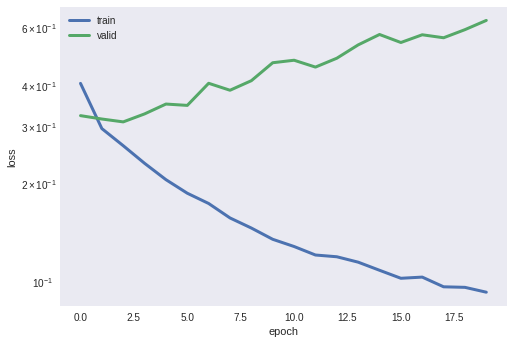

In [23]:
X = X.toarray()
print(X.shape)
X = X.reshape((X.shape[0],X.shape[1],1))
print(X.shape)

X_test = X_test.toarray()
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print(X.shape)
print(X_test.shape)

model = cnn_modelv1(input_shape=X.shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=20)
test_model(model,X_test,y_test)
plot_loss(hist)

### **Without Stop words**

In [29]:
train_file = './data/train.data' #floyd
test_file = './data/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

print("Tokenizing")
X,X_test = ngram_tokenize(X,X_test,max_features=6000,ngram=(1,1))
print(X.shape)
print(X_test.shape)

Found train File ./data/train.data.
Found 25000 samples for train
Found test File ./data/test.data.
Found 25000 samples for test
Tokenizing
(25000, 6000)
(25000, 6000)


(25000, 6000)
(25000, 6000, 1)
(25000, 6000, 1)
(25000, 6000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 6000, 1)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5998, 64)          256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2999, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 191936)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                9596850   
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (De

20000/20000 [==============================] - 38s 2ms/step - loss: 0.3785 - acc: 0.8371 - val_loss: 0.3452 - val_acc: 0.8524
Epoch 2/20
 7680/20000 [==========>...................] - ETA: 21s - loss: 0.2539 - acc: 0.9001

20000/20000 [==============================] - 38s 2ms/step - loss: 0.2668 - acc: 0.8929 - val_loss: 0.3202 - val_acc: 0.8736
Epoch 3/20
 9792/20000 [=============>................] - ETA: 17s - loss: 0.2006 - acc: 0.9218

20000/20000 [==============================] - 38s 2ms/step - loss: 0.2158 - acc: 0.9157 - val_loss: 0.3336 - val_acc: 0.8704
Epoch 4/20
10592/20000 [==============>...............] - ETA: 16s - loss: 0.1681 - acc: 0.9339

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1698 - acc: 0.9331 - val_loss: 0.4051 - val_acc: 0.8662
Epoch 5/20
10880/20000 [===============>..............] - ETA: 15s - loss: 0.1440 - acc: 0.9452

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1470 - acc: 0.9440 - val_loss: 0.4109 - val_acc: 0.8648
Epoch 6/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.1175 - acc: 0.9535

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1263 - acc: 0.9497 - val_loss: 0.4425 - val_acc: 0.8710
Epoch 7/20
11040/20000 [===============>..............] - ETA: 15s - loss: 0.1093 - acc: 0.9556

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1162 - acc: 0.9535 - val_loss: 0.4751 - val_acc: 0.8680
Epoch 8/20
11072/20000 [===============>..............] - ETA: 15s - loss: 0.1002 - acc: 0.9604

20000/20000 [==============================] - 38s 2ms/step - loss: 0.1030 - acc: 0.9585 - val_loss: 0.5171 - val_acc: 0.8724
Epoch 9/20
11072/20000 [===============>..............] - ETA: 15s - loss: 0.0920 - acc: 0.9633

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0990 - acc: 0.9611 - val_loss: 0.4758 - val_acc: 0.8690
Epoch 10/20
11040/20000 [===============>..............] - ETA: 15s - loss: 0.0830 - acc: 0.9667

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0867 - acc: 0.9645 - val_loss: 0.5407 - val_acc: 0.8676
Epoch 11/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0707 - acc: 0.9694

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0782 - acc: 0.9684 - val_loss: 0.5502 - val_acc: 0.8622
Epoch 12/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0750 - acc: 0.9686

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0776 - acc: 0.9676 - val_loss: 0.5674 - val_acc: 0.8602
Epoch 13/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0698 - acc: 0.9712

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0712 - acc: 0.9704 - val_loss: 0.6058 - val_acc: 0.8632
Epoch 14/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0627 - acc: 0.9733

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0685 - acc: 0.9716 - val_loss: 0.5849 - val_acc: 0.8622
Epoch 15/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0661 - acc: 0.9710

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0660 - acc: 0.9711 - val_loss: 0.6417 - val_acc: 0.8662
Epoch 16/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0622 - acc: 0.9750

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0674 - acc: 0.9731 - val_loss: 0.5823 - val_acc: 0.8640
Epoch 17/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0543 - acc: 0.9764

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0589 - acc: 0.9753 - val_loss: 0.6202 - val_acc: 0.8694
Epoch 18/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0578 - acc: 0.9744

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0631 - acc: 0.9724 - val_loss: 0.6557 - val_acc: 0.8708
Epoch 19/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0580 - acc: 0.9753

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0615 - acc: 0.9750 - val_loss: 0.6351 - val_acc: 0.8646
Epoch 20/20
11008/20000 [===============>..............] - ETA: 15s - loss: 0.0497 - acc: 0.9782

20000/20000 [==============================] - 38s 2ms/step - loss: 0.0523 - acc: 0.9773 - val_loss: 0.6621 - val_acc: 0.8678
Testing model on 25000
Test Accuracy: 86.692000


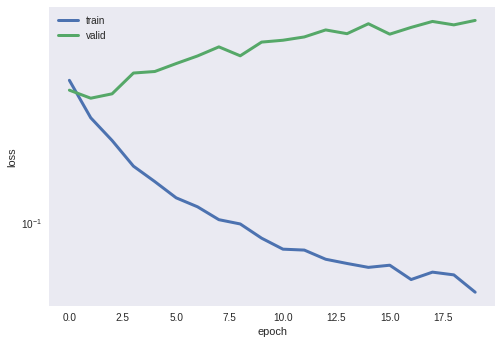

In [30]:
X = X.toarray()
print(X.shape)
X = X.reshape((X.shape[0],X.shape[1],1))
print(X.shape)

X_test = X_test.toarray()
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print(X.shape)
print(X_test.shape)

model = cnn_modelv1(input_shape=X.shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=20)
test_model(model,X_test,y_test)
plot_loss(hist)

### Increasing number of CNN layers

In [4]:
train_file = './data_stopwords/train.data' #floyd
test_file = './data_stopwords/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

print("Tokenizing")
X,X_test = ngram_tokenize(X,X_test,max_features=5000,ngram=(1,1))

X = X.toarray()
X = X.reshape((X.shape[0],X.shape[1],1))

X_test = X_test.toarray()
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

print(X.shape)
print(X_test.shape)

Found train File ./data_stopwords/train.data.
Found 25000 samples for train
Found test File ./data_stopwords/test.data.
Found 25000 samples for test
Tokenizing
(25000, 5000, 1)
(25000, 5000, 1)


Using TensorFlow backend.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4998, 16)          64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2499, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2497, 32)          1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1248, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 39936)             0         
___________________________________________________________

20000/20000 [==============================] - 21s 1ms/step - loss: 0.4022 - acc: 0.8262 - val_loss: 0.3234 - val_acc: 0.8670
Epoch 2/20
20000/20000 [==============================] - 20s 986us/step - loss: 0.2783 - acc: 0.8860 - val_loss: 0.3264 - val_acc: 0.8642
Epoch 3/20
 1504/20000 [=>............................] - ETA: 16s - loss: 0.2345 - acc: 0.9129

20000/20000 [==============================] - 19s 971us/step - loss: 0.2278 - acc: 0.9082 - val_loss: 0.3217 - val_acc: 0.8676
Epoch 4/20
20000/20000 [==============================] - 20s 984us/step - loss: 0.1832 - acc: 0.9274 - val_loss: 0.3720 - val_acc: 0.8680
Epoch 5/20
  992/20000 [>.............................] - ETA: 17s - loss: 0.1413 - acc: 0.9466

20000/20000 [==============================] - 19s 974us/step - loss: 0.1434 - acc: 0.9465 - val_loss: 0.3812 - val_acc: 0.8680
Epoch 6/20
20000/20000 [==============================] - 19s 969us/step - loss: 0.1064 - acc: 0.9586 - val_loss: 0.4225 - val_acc: 0.8642
Epoch 7/20
  864/20000 [>.............................] - ETA: 17s - loss: 0.0707 - acc: 0.9838

20000/20000 [==============================] - 19s 971us/step - loss: 0.0775 - acc: 0.9716 - val_loss: 0.4677 - val_acc: 0.8626
Epoch 8/20
20000/20000 [==============================] - 19s 972us/step - loss: 0.0663 - acc: 0.9755 - val_loss: 0.4921 - val_acc: 0.8676
Epoch 9/20
  864/20000 [>.............................] - ETA: 17s - loss: 0.0494 - acc: 0.9803

20000/20000 [==============================] - 19s 968us/step - loss: 0.0591 - acc: 0.9783 - val_loss: 0.5415 - val_acc: 0.8626
Epoch 10/20
20000/20000 [==============================] - 20s 975us/step - loss: 0.0540 - acc: 0.9805 - val_loss: 0.5569 - val_acc: 0.8624
Epoch 11/20
  800/20000 [>.............................] - ETA: 17s - loss: 0.0255 - acc: 0.9900

20000/20000 [==============================] - 19s 971us/step - loss: 0.0403 - acc: 0.9858 - val_loss: 0.6063 - val_acc: 0.8668
Epoch 12/20
20000/20000 [==============================] - 19s 974us/step - loss: 0.0410 - acc: 0.9843 - val_loss: 0.6280 - val_acc: 0.8612
Epoch 13/20
  800/20000 [>.............................] - ETA: 17s - loss: 0.0179 - acc: 0.9938

20000/20000 [==============================] - 19s 971us/step - loss: 0.0365 - acc: 0.9871 - val_loss: 0.6339 - val_acc: 0.8624
Epoch 14/20
20000/20000 [==============================] - 19s 973us/step - loss: 0.0348 - acc: 0.9873 - val_loss: 0.6679 - val_acc: 0.8654
Epoch 15/20
  800/20000 [>.............................] - ETA: 17s - loss: 0.0263 - acc: 0.9900

20000/20000 [==============================] - 19s 972us/step - loss: 0.0348 - acc: 0.9869 - val_loss: 0.6040 - val_acc: 0.8608
Epoch 16/20
20000/20000 [==============================] - 19s 972us/step - loss: 0.0327 - acc: 0.9880 - val_loss: 0.6381 - val_acc: 0.8620
Epoch 17/20
  800/20000 [>.............................] - ETA: 18s - loss: 0.0292 - acc: 0.9888

20000/20000 [==============================] - 20s 977us/step - loss: 0.0282 - acc: 0.9896 - val_loss: 0.7236 - val_acc: 0.8668
Epoch 18/20
20000/20000 [==============================] - 19s 973us/step - loss: 0.0289 - acc: 0.9895 - val_loss: 0.7110 - val_acc: 0.8680
Epoch 19/20
  800/20000 [>.............................] - ETA: 17s - loss: 0.0215 - acc: 0.9938

20000/20000 [==============================] - 19s 970us/step - loss: 0.0284 - acc: 0.9897 - val_loss: 0.6752 - val_acc: 0.8668
Epoch 20/20
20000/20000 [==============================] - 19s 970us/step - loss: 0.0252 - acc: 0.9912 - val_loss: 0.6977 - val_acc: 0.8624
Testing model on 25000
Test Accuracy: 87.356000


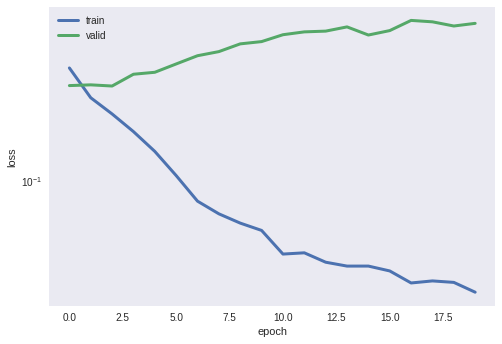

In [5]:
def cnn_modelv2(input_shape):

  from keras.models import Model
  from keras.layers import Input, Dense, Dropout,Conv1D,MaxPooling1D,Flatten

  input_layer = Input(shape=(input_shape[1],input_shape[2],))
  x = Conv1D(16, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_layer)
  x = MaxPooling1D(pool_size=2, strides=None, padding='valid')(x)

  x = Conv1D(32, 3, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, 
      bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x)
  x = MaxPooling1D(pool_size=2, strides=None, padding='valid')(x)

  x = Flatten()(x)
  x = Dense(200,activation='relu')(x)
  x = Dropout(0.5)(x)
  # x = Dense(128,activation='relu')(x)
  # x = Dropout(0.5)(x)
  output_layer = Dense(1,activation='sigmoid')(x)
  model = Model(inputs=input_layer, outputs=output_layer)

  model.summary()

  return model

model = cnn_modelv2(input_shape=X.shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=20)
test_model(model,X_test,y_test)
plot_loss(hist)